# Example 4: Soil moisture retrieval with real data set

## 1. Narrative (Inversion of RT-models, soil moisture retrieval from radar backscatter)

This notebook demonstrates a workflow for retrieving soil moisture (sm) from radar backscatter (**real data set**).

The process follows three main steps:
1. **Parametrization**: Defining the physical properties of the soil and vegetation.
2. **Forward Modeling** (creating a synthetic dataset): Simulating what a microwave satellite (e.g., Sentinel-1) would "see" (backscatter) given the parametrization of the soil and vegetation.
3. **Inversion**: Using an optimization solver to find the soil moisture value that best matches the 
   observed backscatter.
4. **Visualization**: Visualize the difference between the synthetic created truth of soil moisture (sm_truth) and the modeled soil moisture


## 2. Requirements

- Installation of SenSE
- Import packages

In [8]:
from pathlib import Path

import geopandas as gpd
from shapely.geometry import mapping

from pystac_client import Client
import planetary_computer as pc

import stackstac
import xarray as xr
import numpy as np
import pandas as pd

import rioxarray
import pystac_client
import planetary_computer as pc
import stackstac
from shapely.geometry import box
from rasterio.enums import Resampling
import matplotlib.pyplot as plt


## 3. Get satellite data

### 3.1 Load the Area of Interest (AOI) from a Shapefile

In [9]:
# This identifies the directory where your notebook is located
base_path = Path.cwd()

# Construct the path to the shapefile
shp_path = base_path / "data" / "MNI_2017.shp"

# Load shapefile
gdf = gpd.read_file(shp_path)

# Ensure WGS84 (required for STAC search)
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Use the first geometry as AOI
aoi_geom = mapping(gdf.geometry.iloc[0])

### 3.2 Connect to Planetary Computer STAC

In [10]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

### 3.3.1 Sentinel-1 GRD (Sigma⁰, Terrain-Corrected) - ***Problem: no crs within the stac catalog - not working right now but maybe in the future***

In [11]:
s1_search = catalog.search(
    collections=["sentinel-1-grd"],
    datetime="2017-03-01/2017-06-30",
    intersects=aoi_geom,
    query={
        "sar:instrument_mode": {"eq": "IW"},
    },
    max_items=100,  # IMPORTANT: avoids backend overload
)

s1_items = list(s1_search.get_items())

s1 = stackstac.stack(
    s1_items,
    assets=["vv"],
    epsg=32632,          
    resolution=10,
    bounds_latlon=gdf.total_bounds.tolist(),
    chunksize=2048,
)


/root/.local/lib/python3.12/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


### 3.3.2 Get Sentinel-1 Sigma nought values from pre processed dataset (npy files for vv and time as well as spatial extent from tif file)

In [13]:
# 1. Metadaten aus der TIFF-Datei extrahieren
tif_ref = rioxarray.open_rasterio('data/clipped_reference.tif')

# Wir holen uns die Bounding Box in den Koordinaten des TIFFs (z.B. UTM)
# und transformieren sie in Lat/Lon (4326) für die STAC-Suche
bbox_4326 = tif_ref.rio.transform_bounds(4326)
aoi_geom = box(*bbox_4326) # Erstellt ein Shapely-Polygon


# 1. Deine SAR-Daten (S1) als xarray vorbereiten (wie besprochen)
time_s1 = pd.to_datetime(np.load('data/clipped_time.npy', allow_pickle=True))
vv_data = np.load('data/clipped_backscatter.npy')

s1_xr = xr.DataArray(
    vv_data,
    coords={"time": time_s1, "y": tif_ref.y, "x": tif_ref.x},
    dims=["time", "y", "x"]
).rio.write_crs(tif_ref.rio.crs)




# 1. Daten laden
# Shape ist vermutlich (Zeit, Y, X) oder (Y, X)
inc_data = np.load('data/clipped_theta.npy') 

# 2. In ein DataArray umwandeln (mit den Koordinaten aus dem TIFF)
inc_xr = xr.DataArray(
    inc_data,
    coords={"time": time_s1, "y": tif_ref.y, "x": tif_ref.x},
    dims=["time", "y", "x"]
).rio.write_crs(tif_ref.rio.crs)






### 3.5 Sentinel-2 Level-2A (Atmospherically Corrected)

In [14]:
s2_search = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2017-03-01/2017-06-30",
    intersects=aoi_geom, 
    query={"eo:cloud_cover": {"lt": 20}},
)

# 3. Items signieren (um 403-Fehler zu vermeiden)
s2_items = [pc.sign(item) for item in s2_search.get_items()]

# 4. Den Stack erstellen - Exakt angepasst an dein TIFF
s2_stack = stackstac.stack(
    s2_items,
    assets=["B04", "B08"],   # Rot und NIR für NDVI
    epsg=tif_ref.rio.crs.to_epsg(),
    resolution=tif_ref.rio.transform()[0], # Übernimmt Pixelgröße (z.B. 10m)
    bounds=tif_ref.rio.bounds(),          # Nutzt exakte Grenzen des TIFFs
)

# 5. NDVI berechnen
red = s2_stack.sel(band="B04").astype(float)
nir = s2_stack.sel(band="B08").astype(float)
ndvi = (nir - red) / (nir + red)


/root/.local/lib/python3.12/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


### 3.6 Format satellite data (same extent, same pixel size, same time frame)

In [15]:

# 1. Duplikate auf der Zeitachse entfernen
# Wir gruppieren nach 'time' und nehmen .mean(), falls Werte doppelt sind
ndvi_unique = ndvi.groupby("time").mean()

# 2. Jetzt klappt die Interpolation ohne Fehler
ndvi_interp = ndvi_unique.interp(time=s1_xr.time, method="linear")

# 3. Zusammenführen
ds = xr.Dataset({
    "backscatter_db": 10 * np.log10(s1_xr.where(s1_xr > 0)),
    "ndvi": ndvi_interp
})

In [16]:

# 1. SAR-Daten auf exakt 10m bringen
# Bilineares Resampling verhindert "harte Kanten" bei der Skalierung
s1_10m = s1_xr.rio.reproject(
    s1_xr.rio.crs, 
    resolution=10, 
    resampling=Resampling.bilinear
)

# 3. Auf 10m Auflösung reprojizieren (analog zu VV)
inc_10m = inc_xr.rio.reproject(
    inc_xr.rio.crs, 
    resolution=10, 
    resampling=Resampling.bilinear
)

# 2. NDVI-Stack an das 10m S1-Gitter anpassen
# reproject_match sorgt dafür, dass jeder Pixel von S2 über dem von S1 liegt
ndvi_10m = ndvi_unique.rio.reproject_match(s1_10m)

# 3. Zeitliche Interpolation
ndvi_interp = ndvi_10m.interp(time=s1_10m.time, method="linear")

# 4. Finales Dataset erstellen
ds_10m = xr.Dataset({
    "backscatter_db": 10 * np.log10(s1_10m.where(s1_10m > 0)),
    "ndvi": ndvi_interp,
    "incidence_angle": inc_10m
})



print("Success: Dataset ist nun auf 10m harmonisiert.")

Success: Dataset ist nun auf 10m harmonisiert.


Bestätigte Auflösung: 10.0m x 10.0m


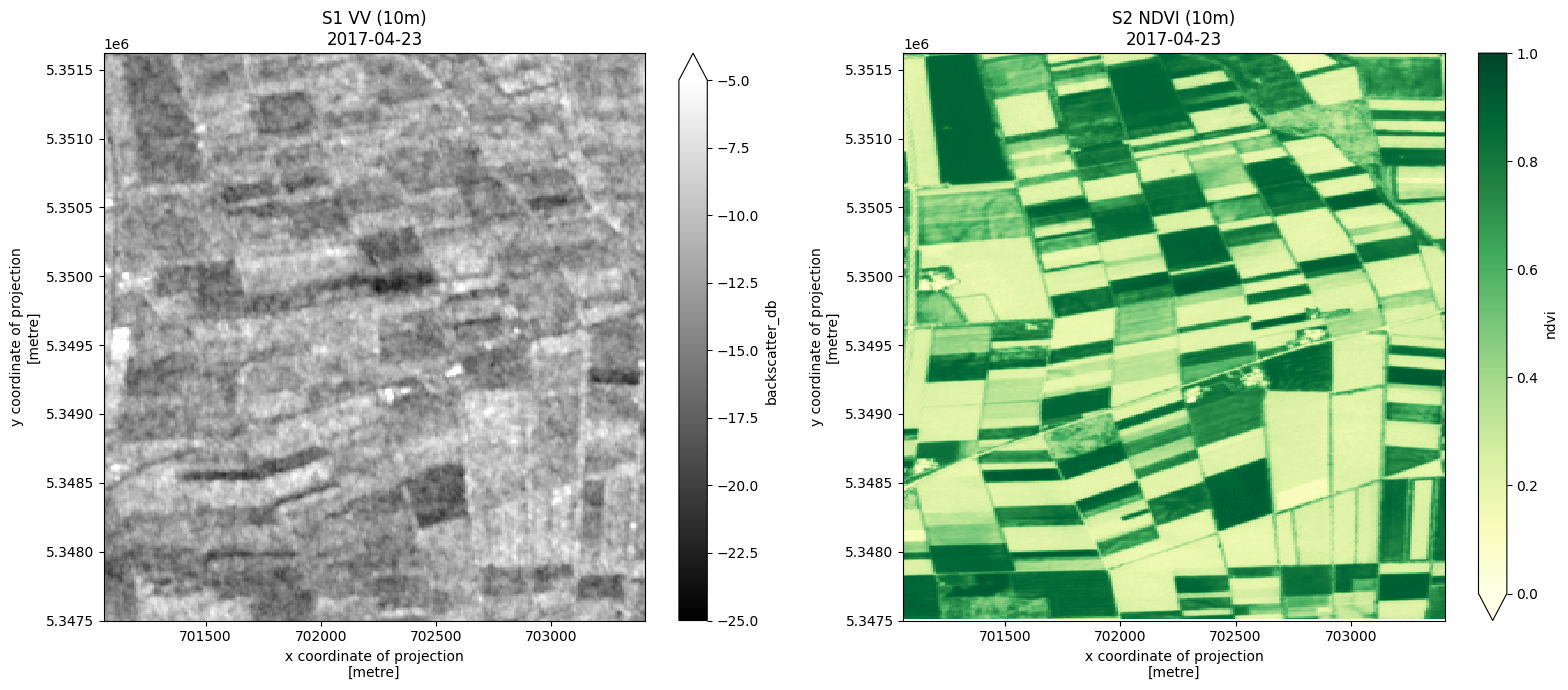

In [17]:
# Check dataset visually

# Ersten Zeitschritt wählen
t0 = ds_10m.isel(time=20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# S1 Plot
t0.backscatter_db.plot(ax=ax1, cmap='gray', vmin=-25, vmax=-5)
ax1.set_title(f"S1 VV (10m)\n{str(t0.time.values)[:10]}")

# NDVI Plot
t0.ndvi.plot(ax=ax2, cmap='YlGn', vmin=0, vmax=1)
ax2.set_title(f"S2 NDVI (10m)\n{str(t0.time.values)[:10]}")

# Optional: Ein kleiner Check-Print für dich
res_y, res_x = ds_10m.rio.resolution()
print(f"Bestätigte Auflösung: {abs(res_x)}m x {abs(res_y)}m")

plt.tight_layout()
plt.show()

### 3.7 Get data set for a specific area of interest (field based on shapefile)

In [18]:


# 1. Shapefile laden
fields_gdf = gpd.read_file('data/MNI_2017.shp')
fields_gdf = fields_gdf.to_crs(ds_10m.rio.crs)

# 3. Ein spezifisches Feld auswählen (z.B. das erste)
# Du kannst auch filtern, z.B. fields_gdf[fields_gdf['name'] == 'Feld_A']
single_field = fields_gdf[fields_gdf['NUMMER'] == 542] # values are 515, 542, 508, 319, 301

print(single_field)




  ID  NUMMER  TEILNUM  NAME  FLAECHE BETRIEBSNU FRUCHTART       Frucht_lan  \
1  8     542        0  K 16     10.3         40        TR  Wintertriticale   

                                            geometry  
1  POLYGON ((703011.559 5351582.461, 703039.159 5...  


In [19]:
# 1. Das Dataset (inkl. incidence_angle) auf das Feld zuschneiden
field_clipped = ds_10m.rio.clip(single_field.geometry, single_field.crs)

# 2. Räumlichen Mittelwert für alle Variablen berechnen
field_mean = field_clipped.mean(dim=["x", "y"])

# 3. Backscatter in linearen Raum umrechnen
vv_linear_xr = 10**(field_mean.backscatter_db / 10)

# 4. Synchronisieren: Nur Zeitpunkte behalten, wo KEINE NaNs in allen 3 Variablen sind
valid_indices = (
    field_mean.ndvi.notnull() & 
    field_mean.backscatter_db.notnull() & 
    field_mean.incidence_angle.notnull()
)


# Inzidenzwinkel in Grad extrahieren
inc_deg = field_mean.incidence_angle.where(valid_indices, drop=True).values

# --- UMRECHNUNG IN RADIANTEN ---
inc_rad = np.deg2rad(inc_deg) 
# Alternativ: inc_rad = inc_deg * (np.pi / 180)

# 5. Finale Parameter speichern
# Wir wenden .where(valid_indices, drop=True) auf alle Komponenten an
vv = vv_linear_xr.where(valid_indices, drop=True).values
ndvi = field_mean.ndvi.where(valid_indices, drop=True).values
inc_deg = field_mean.incidence_angle.where(valid_indices, drop=True).values
inc_rad = np.deg2rad(inc_deg)

# ZEIT ALS ARRAY EXTRAHIEREN:
# Anstatt field_sync zu nutzen, filtern wir field_mean.time mit valid_indices
vv_time = field_mean.time.where(valid_indices, drop=True).values 


vv_time_datetime = pd.to_datetime(vv_time)



### Visualize data set for field

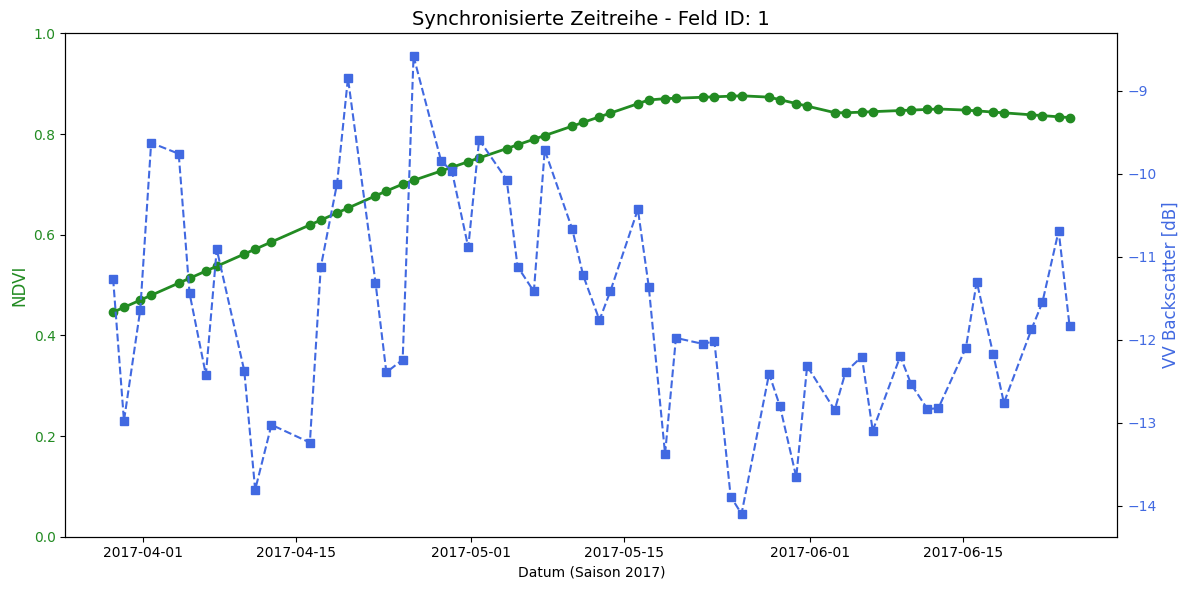

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))



# NDVI Plot
color_ndvi = 'forestgreen'
ax1.set_xlabel('Datum (Saison 2017)')
ax1.set_ylabel('NDVI', color=color_ndvi, fontsize=12)
ax1.plot(vv_time_datetime, ndvi, color=color_ndvi, marker='o', linewidth=2, label='NDVI')
ax1.tick_params(axis='y', labelcolor=color_ndvi)
ax1.set_ylim(0, 1)

# Backscatter Plot
ax2 = ax1.twinx()
color_vv = 'royalblue'
ax2.set_ylabel('VV Backscatter [dB]', color=color_vv, fontsize=12)
ax2.plot(vv_time_datetime, 10 * np.log10(vv), color=color_vv, marker='s', linestyle='--', label='VV Radar')
ax2.tick_params(axis='y', labelcolor=color_vv)

# Titel und Layout
plt.title(f"Synchronisierte Zeitreihe - Feld ID: {single_field.index[0]}", fontsize=14)
fig.tight_layout()
plt.show()

## 3. Retrieval of soil moisture with RT-model combination **Oh92+Water Cloud Model**

### 3.1 Parametrization

First of all, we need to import several packages

In [21]:
import numpy as np
#from sense.surface import Dubois95
from sense.util import f2lam
from sense.model import RTModel
from sense.soil import Soil
from sense.canopy import OneLayer
import matplotlib.pyplot as plt
import random
from sense.surface import Oh92, Oh04
from scipy.optimize import minimize

Define which RT models should be used (example combination of surface: Oh92 and canopy: SSRT)

In [22]:
# Choose models (surface: Oh92; canopy: watercloud)
#------------------------------------------------------------------
canopy = 'water_cloud' # other options are 'turbid_rayleigh' or 'water_cloud' 
surface = 'Oh92' # other options are 'Oh04", 'Dubois95', 'I2EM', 'WaterCloud'
models = {'surface' : surface, 'canopy' : canopy}
pol='vv' # use of Vertical-Vertical polarization due to its sensitivity to soil moisture

Define model parameters. For the parameter soil moisture (sm) a synthetic time series is created

In [23]:
# model parameter Oh92 (surface part)
#----------------------
freq = 5.405           # Frequency in GHz (C-band, typical for Sentinel-1)
s = 0.02              # Surface roughness (m)
clay = 0.0738          # Clay fraction (0-1)
sand = 0.2408          # Sand fraction (0-1)
bulk = 1.45            # Soil bulk density (g/cm3)
theta = inc_rad # Incidence angle in radians

# Generating a synthetic time series of soil moisture
sm_truth = np.random.uniform(low=0.05, high=0.35, size=(50,))

# model parameter watercloud (canopy part)
#---------------------
A_vv = 0.0950
A_hh = 0.1
A_hv = 0.1
B_vv = 0.5513
B_hh = 0.1 
B_hv = 0.1
V1 = ndvi*1
V2 = ndvi*1

### 3.2 Forward modeling

Forward simulation. Using the previously defined model parameter to create a "synthetic truth" dataset of sigma nought radar backscatter values.

Let's put some uncertainty (15%) on the synthetic (truth) backscatter time series

In [24]:
back_vv = vv*1.
back_hv = vv*1

### 3.3 Inversion

Define some helper function so that we can run the RT model in an inversion process. The aim is to provide backscatter to the RT model thus we can retrieve soil moisture values 

In [25]:
# Helper Functions for Soil Moisture Retrieval (Inversion)
# ---------------------------------------------------------

def run_model(dic, models):
    """
    Executes the Forward Radiative Transfer Model.
    This function takes physical parameters (soil moisture, roughness, vegetation)
    and simulates what the radar backscatter (sigma0) should look like.
    """
    
    # 1. Define Soil Properties: 
    # mv = volumetric soil moisture, s = surface roughness, f = frequency
    soil = Soil(mv=dic['mv'], s=dic['s'], clay=dic['clay'], 
                sand=dic['sand'], f=dic['f'], bulk=dic['bulk'])

    # 2. Define Canopy (Vegetation) Properties:
    # d = height, ke = extinction coefficient, omega = single scattering albedo
    # We calculate scattering coefficients (ks) based on the extinction and albedo.
    can = OneLayer(canopy=dic['canopy'], 
                   A_vv = dic['A_vv'],
                   A_hh = dic['A_hh'],
                   A_hv = dic['A_hv'],
                   B_vv = dic['B_vv'],
                   B_hh = dic['B_hh'],
                   B_hv = dic['B_hv'],
                   V1 = dic['V1'],
                   V2 = dic['V2'],
                   )

    # 3. Combine into the Radiative Transfer Model (RTModel):
    # theta = incidence angle of the satellite sensor
    S = RTModel(surface=soil, canopy=can, models=models, theta=dic['theta'], freq=dic['f'])
    
    # Run the simulation
    S.sigma0()
    
    # Return the total backscatter for VV and VH polarizations
    # Note: [::-1] is used here to ensure the dictionary key matches the internal naming
    return S.__dict__['stot']['vv'[::-1]], S.__dict__['stot']['vh'[::-1]]


def solve_fun(VALS, var_opt, dic, models):
    """
    Bridge function that updates the parameter dictionary with the 
    current 'guess' from the optimizer and runs the model.
    """
    for i in range(len(var_opt)):
        dic[var_opt[i]] = VALS[i]

    vv, vh = run_model(dic, models)
    return vv, vh


def fun_opt(VALS, var_opt, dic, models, pol):
    """
    The Objective (Cost) Function.
    This calculates the 'error' between the satellite observation and our model.
    The optimizer tries to minimize this value to find the true soil moisture.
    """
    
    # We use Least Squares (np.square) to penalize larger differences between 
    # the observed data (dic['vv']) and the simulated data (solve_fun(...)).
    
    if pol == 'vv':
        # Minimize error for VV polarization only
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])))
    
    elif pol == 'vh':
        # Minimize error for VH polarization only (often used for vegetation)
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])))
    
    elif pol == 'vv_vh':
        # Dual-polarization retrieval: seeks a balance that fits both VV and VH signals
        return(np.nansum(np.square((solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])/2 + 
                                   (solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])/2)))

Now we can run the inversion process to estimate soil moisture based on a synthetic radar backscatter time series

In [26]:
# Execution of the Soil Moisture Retrieval (Inversion Loop)
# ---------------------------------------------------------

# Initial Dictionary: Stores all constant physical and sensor parameters.
# These values (roughness, clay content, frequency, etc.) are held constant 
# while we solve for the unknown variable (soil moisture).
dic = {
    "mv": 0.2,      # Initial placeholder for soil moisture
    "s": s,         # Soil roughness (m)
    "clay": clay,   # Clay fraction
    "sand": sand,   # Sand fraction
    "f": freq,      # Radar frequency (GHz)
    "bulk": bulk,   # Soil bulk density
    "canopy": canopy, 
    "vv": back_vv,  # VV Polarization backscatter (Target)
    "vh": back_hv,  # VH Polarization backscatter
    "theta": theta, # Incidence angle
    "A_vv": A_vv,  # 
    "A_hh": A_hh,  # 
    "A_hv": A_hv,  # 
    "B_vv": B_vv,  # 
    "B_hh": B_hh,  # 
    "B_hv": B_hv,  # 
    "V1": ndvi,  # 
    "V1": ndvi,  # 
}

# Optimization Configuration
var_opt = ['mv']      # The variable we want to retrieve (Soil Moisture)
guess = [0.2]         # The starting point for the solver (20% moisture)
bounds = [(0.05, 0.35)] # Physical limits: prevents the solver from picking impossible values

# 'L-BFGS-B' is a common algorithm for "constrained" optimization.
# It is efficient for finding the minimum of a function within specific bounds.
method = 'L-BFGS-B'

# List to store the results for each time-step or pixel
sm_retrieved = []

# Loop through each radar observation (Backscatter time-series or array)
for i, ii in enumerate(back_vv):
    
    # Update the dictionary with the specific observation for this iteration.
    # We feed the solver the exact backscatter (VV and VH) measured by the satellite.
    dic = {
        "mv": 0.2, "s": s, "clay": clay, "sand": sand, "f": freq, "bulk": bulk, 
        "canopy": canopy, "vv": back_vv[i], "vh": back_hv[i], 
        "theta": theta, "A_vv": A_vv, "A_hh": A_hh, "A_hv": A_hv, "B_vv": B_vv
        , "B_hh": B_hh, "B_hv": B_hv, "V1": ndvi[i], "V2": ndvi[i]
    }
    
    # The Minimize function:
    # It repeatedly calls 'fun_opt', adjusting the 'mv' value until the 
    # simulated backscatter matches the observed backscatter (back_vv[i]).
    res = minimize(fun_opt, guess, args=(var_opt, dic, models, pol), 
                   bounds=bounds, method=method)

    # Optional: Execute the function one last time with the optimized result 
    # to verify the final cost/error.
    fun_opt(res.x, var_opt, dic, models, 'vv')
    
    # Append the successful retrieval (res.x[0]) to our results list
    sm_retrieved.append(res.x[0])

# Result: 'sm_retrieved' now contains the estimated soil moisture values
# corresponding to your radar backscatter inputs.


### Get in situ measurements

In [27]:
# 1. CSV laden
df_raw = pd.read_csv('data/in_situ_s1.csv', header=[0, 1])

# 2. Die Datumsspalte sicher identifizieren
# Wir suchen die Spalte, die im zweiten Level 'date' (oder 'Date') heißt
date_col = [c for c in df_raw.columns if 'date' in str(c[1]).lower()][0]

# 3. Konvertierung mit explizitem Format (beschleunigt es und vermeidet die Warnung)
df_raw[date_col] = pd.to_datetime(
    df_raw[date_col], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

# 4. Nur Zeilen löschen, wo das Datum wirklich Schrott ist
df_raw = df_raw[df_raw[date_col].notnull()]

# 5. Datum als Index setzen
df_raw = df_raw.set_index(date_col)

# 6. Daten extrahieren
field_sm_data = {}
# Wir filtern die echten Feldnamen (Level 0)
field_names = [f for f in df_raw.columns.get_level_values(0).unique() if 'Unnamed' not in str(f)]

for field in field_names:
    # Wir greifen auf die Spalte 'SM' zu
    if 'SM' in df_raw[field].columns:
        # Extraktion und Umwandlung in Floats
        sm_values = pd.to_numeric(df_raw[field]['SM'], errors='coerce')
        # Wir behalten nur Zeilen mit Werten
        sm_series = sm_values.dropna()
        
        if not sm_series.empty:
            field_sm_data[field] = sm_series

# Check
if field_sm_data:
    first_field = list(field_sm_data.keys())[0]
    print(f"Erfolgreich extrahiert: {first_field}")
    print(field_sm_data[first_field].head())
else:
    print("Keine Daten gefunden. Überprüfe die Spaltennamen für 'SM'.")

Erfolgreich extrahiert: 301_high
(Unnamed: 1_level_0, date)
2017-03-24 05:17:15    0.2263
2017-03-25 17:06:21    0.2227
2017-03-26 16:58:53    0.2179
2017-03-29 05:25:29    0.2050
2017-03-30 05:18:04    0.2010
Name: SM, dtype: float64


### 3.4 Visualization

Let's see how the original soil moisture compares to the model retrieved soil moisture (remember we put some uncertainty on the synthetic radar backscatter time series)

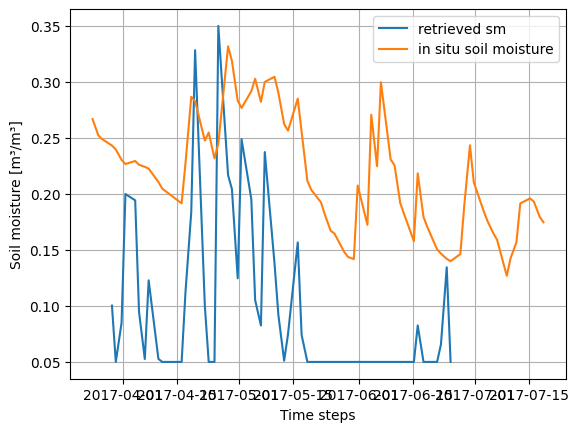

In [28]:
# Visualization
# --------------
plt.plot(pd.to_datetime(vv_time_datetime), sm_retrieved, label='retrieved sm')
plt.plot(pd.to_datetime(field_sm_data['542_high'].index), field_sm_data['542_high'].values, label='in situ soil moisture')
plt.xlabel('Time steps')
plt.ylabel('Soil moisture [m³/m³]')
plt.grid()
plt.legend()